# Face Recognition

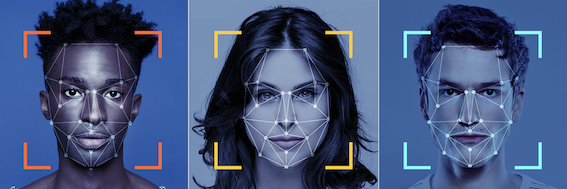

In this homework you'll dive into face recognition framework and train neural network for face recognition task, play with losses and metrics.

We will train neural network on [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

As you see on the site, images of celebA dataset look like this:


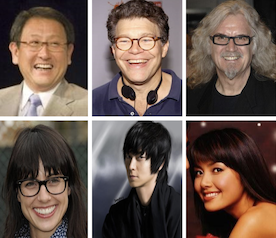

But we won't train a neural network for face recognition on those images. We'll need to preprocess them first. Let's see why we need it and how we need to preprocess them.

Let's look at how face recognition systems work:

## Face recognition model training and inference setup

This section describes how face recognition models are trained, what data alignment is and how the inference of face recognition model looks like. If you are familiar with this, you can skip this section.

### Model training

To train face recognition model on any facial dataset images must be aligned first. This step is very important to achieve a good quality of face recognition.

What is alignment: it consists of three steps:
1. Given image, identify facial landmarks on the image (coordinates of eyes, nose and mouth points). Separate neural network can be used there which was trained to identify landmarks on facial images. You can refer to [PyTorch Landmarks tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to see how this works.
2. Rotate all the images in the dataset so that eyes of the person on every image lie on a certain pre-defined horizontal line.
3. Scale all the images in the dataset so that the size of the faces are approximately identical.

Here's an example of what we would get after alignment of all the images of Aaron Peirsol from our dataset:

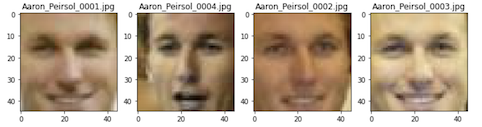

You see that eyes of all the faces lie on one horizontal line and all the faces have almost the same size. If we align all the images in the dataset, we can then train a neural network on aligned images.

**Why we need the alignment procedure**: the alignment of all faces in dataset makes the task of facial recognition easier for the model. If all the faces that model sees are of the same size and have their landmarks (eyes, nose, etc) on almost the same parts of the images, it is easier for the model to learn to identify a person on the image. The model diesn't need to "search" for the face and eyes positions on the image befire performing a recognition.

If you are interested, you can also train a model on non-aligned images, but you'll see that it would perform badly. It is possible though to train a model for face recognition without pre-alignment of all the faces, but this would require a huge amount of data — more that almost any company has. The only company that has openly presented its face recognition system that does not require special alignment is Facebook — their neural network was trained on a really huge amount of data using a special trick to avoid alignment. You can read more details [here](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)

### Model inference

So let's see how the model trained on aligned faces can be used in real world:

Let's assume you owe a company and you want to build a face recognition system for your working office. You decided to hang some cameras around the office and want them to be able to recognize faces of all your employees when they are sitting / walking around the office (we let you decide by yourself why you would need such a system in your office)


A system for face recognition typically conststs of 3 stages:
- face detection
- face alignment
- face recognition

Let's discuss them in detail:

**Face detection**

When the camera is hanged on the wall it records a video and splits the video into single images, like this:

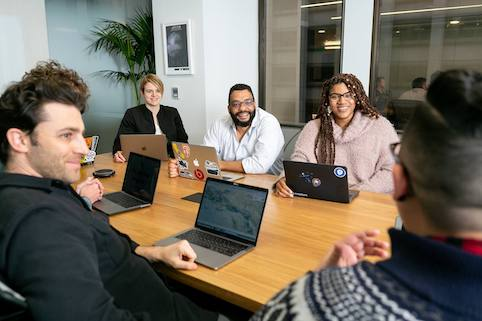

To be able to recognize all the faces on the photo you need first to detect all the faces that are present on the photo, like this:

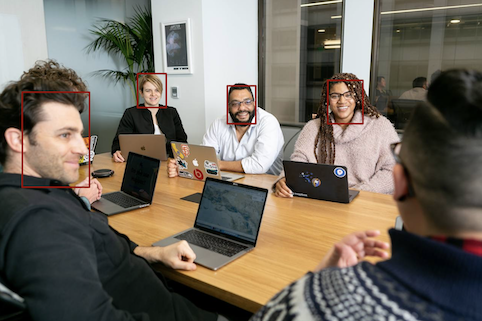

That is the first part — detection. You could use any neural network that can detect humans for this.

**Face alignment**

The second stage is to align all the faces found. The alignment procedure here should be the same as used to align training images.

So we'll get an image of a guy on a photo aligned like this:

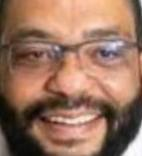

**Face recognition**

On the third stage we use the neural network that we trained to recognize a face.

So that's how the face recognition models pipeline work. You can also read about it more on [this link](https://www.nytimes.com/wirecutter/blog/how-facial-recognition-works/) (and using internet search)

## Neural network model architecture

Let's discuss how model for face recognition should look like.



The easiest and, actually, the most used way to build a neural network for face recognition is to build it as a **simple classifier**.

Assume we have a dataset with photos of N different people. Then we can build a neural network to classify all the images from the dataset into N classes. Each class refers to one unique person in the dataset.

**How do we recognize new people by this network then?** We actually want the network for face recognition to be able to recognize not only the people which are in training set, but almost every person in the world.

That is how: after training the model, we'll drop it's last classification layer. After that when we'll pass an image of the person through network, we'll get the output of the pre-last layer — it's **the embedding of the image**. Having embeddings of two different images we can compare them using **cosine distance**. The less the distance is — the higher the probability that those two photos belong to one person is.

Using that technique we can get embeddings of every image — even of unseen people, compare them, and reveal images belonging to same people.

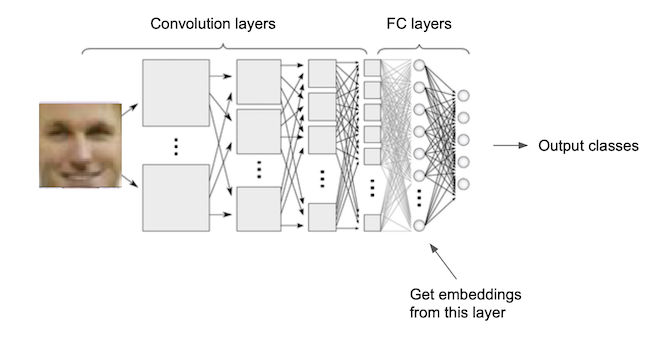

## Task 1 (5 points): build a neural network for faces classification as discribed above.

### Dataset

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw or using the code below:

In [1]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/S8f03spLIA1wrw) -o celebA_train.zip
! unzip -qq celebA_train.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  162M  100  162M    0     0  15.1M      0  0:00:10  0:00:10 --:--:-- 21.4M


Let's look at the data first:

In [2]:
! ls celebA_train_500/

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — folder with aligned images
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [3]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io, transform

import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

Let's visualize some images to understand what we're dealing with:

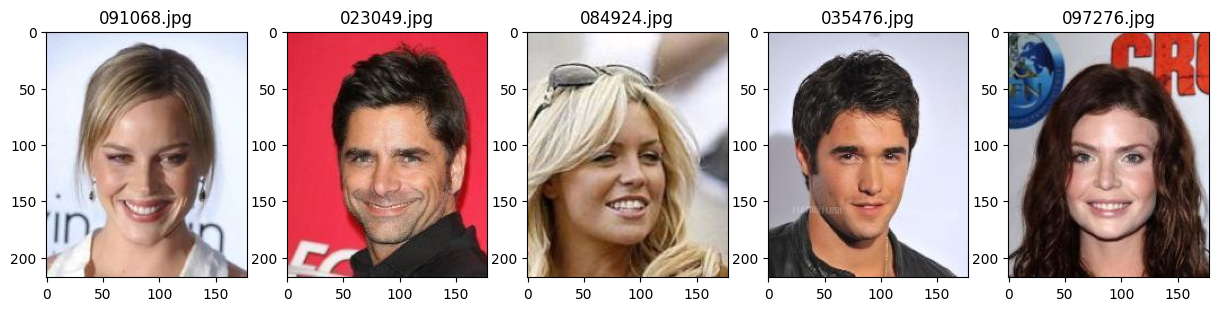

In [4]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_500/celebA_imgs/', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('./celebA_train_500/celebA_imgs/')[:5]
show_imgs(images_names)


### Train Neural Network

Let's build a Datasets and network using this images:

In [5]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:
        images_paths.append(os.path.join('celebA_train_500/celebA_imgs/', filename))

    return np.array(images_paths)


class CelebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_name)

        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }

        sample['image'] = self.transform(sample['image'])

        return sample

In [6]:
transform_train = transforms.Compose([
      transforms.Resize((224, 224)), # Увеличим размер до стандартного для ResNet
      transforms.RandomHorizontalFlip(p=0.5), # Горизонтальное отражение
      transforms.RandomRotation(10), # Небольшой поворот
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Изменение цветов
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_val = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_data = CelebADataset('train', transform_train)
val_data = CelebADataset('val', transform_val)
test_data = CelebADataset('test', transform_val)

# choose your own batch_size
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

**Workflow**: train a model on train_data using val_data for validation. Use standard CE loss. Calculate the loss and accuracy on test set after training. Don't forget to log parameters, loss and metrics to Weights&biases e.g.

You may use whatever model you want, including pre-trained on ImageNet models from torchvision. Please note, that **it is not allowed to use pre-trained models on any other dataset except ImageNet**.

To get higher score, try to adjust hyperparameters, maybe try augmentations, etc.

Hints: Do not use too big model. Small ResNet-like network is enough to get the required score. Use at least 2 linear layers on the bottom. You'll need to drop the last layer after training and get image embeddings from the pre-last layer. It's not required to get the embedding from linear layer though: you may get it from last convolution layer, if you want.

**To get the first half of the mark for this section you need to achieve 70% accuracy on test set**.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

import torch.nn as nn
import torch.optim as optim
from torchvision import models
import wandb


num_classes = len(set(train_data.labels))
print(f"Количество классов: {num_classes}")

# Создание модели с предобученным ResNet18
class FaceRecognitionModel(nn.Module):
    def __init__(self, num_classes, freeze_backbone=True):
        super(FaceRecognitionModel, self).__init__()

        self.backbone = models.resnet18(pretrained=True)

        num_features = self.backbone.fc.in_features

        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        return self.backbone(x)

    def get_embeddings(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)

        embedding = self.backbone.fc[:3](x)
        return embedding




Количество классов: 500


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import wandb
from tqdm import tqdm

def train_epoch(model, dataloader, criterion, optimizer, epoch_index):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f'Epoch {epoch_index} [Train]', leave=False)

    for step, batch in enumerate(pbar):
        images, labels = batch['image'].to(device), batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()


        current_loss = running_loss / (step + 1)
        current_acc = 100. * correct / total
        pbar.set_postfix({'loss': f'{current_loss:.4f}', 'acc': f'{current_acc:.2f}%'})

        wandb.log({"train_batch_loss": loss.item()})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, loss_fn):
    model.eval()
    losses = []
    num_correct = 0
    num_elements = 0

    with torch.no_grad():
        for batch in dataloader:
            X_batch, y_batch = batch['image'].to(device), batch['label'].to(device)

            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)
            losses.append(loss.item())

            y_pred = torch.argmax(logits, dim=1)
            num_correct += torch.sum(y_pred == y_batch).item()
            num_elements += len(y_batch)

    accuracy = num_correct / num_elements
    return accuracy, np.mean(losses)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(set(train_data.labels))

wandb.init(project="face-recognition-celeba", config={
    "architecture": "ResNet18",
    "dataset": "CelebA",
    "batch_size": 64,
    "strategy": "Two-Stage",
    "stage1_epochs": 5,
    "stage2_epochs": 20,
    "stage1_lr": 0.003,
    "stage2_lr": 0.001
})

model = FaceRecognitionModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()

In [ ]:

for param in model.backbone.parameters():
    param.requires_grad = False

for param in model.backbone.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.backbone.fc.parameters(), lr=0.003)

for epoch in range(1, 6):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch)
    val_acc, val_loss = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Acc {val_acc:.2f}")

    wandb.log({
        "stage": 1,
        "epoch": epoch,
        "train_epoch_loss": train_loss,
        "train_epoch_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

total_epochs = 25
best_acc = 0.0

for epoch in range(6, total_epochs + 1):

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch)

    val_acc, val_loss = evaluate(model, val_loader, criterion)
    scheduler.step(val_acc)

    print(f"Epoch {epoch}: Val Loss {val_loss:.4f}, Val Acc {val_acc:.2f}")

    wandb.log({
        "stage": 2,
        "epoch": epoch,
        "train_epoch_loss": train_loss,
        "train_epoch_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

wandb.finish()
print(f"Training finished. Best Validation Accuracy: {best_acc:.2f}")

Epoch 1: Train Loss 5.7250, Val Acc 0.11


Epoch 2: Train Loss 4.3004, Val Acc 0.19


Epoch 3: Train Loss 3.7763, Val Acc 0.22


Epoch 4: Train Loss 3.4490, Val Acc 0.24


Epoch 5: Train Loss 3.1894, Val Acc 0.24


Epoch 6: Val Loss 3.4604, Val Acc 0.25


Epoch 7: Val Loss 3.5645, Val Acc 0.24


Epoch 8: Val Loss 2.7074, Val Acc 0.37


Epoch 9: Val Loss 2.5886, Val Acc 0.41


Epoch 10: Val Loss 2.1844, Val Acc 0.49


Epoch 11: Val Loss 2.3483, Val Acc 0.47


Epoch 12: Val Loss 2.0497, Val Acc 0.52


Epoch 13: Val Loss 1.9896, Val Acc 0.55


Epoch 14: Val Loss 1.7181, Val Acc 0.61


Epoch 15: Val Loss 1.5610, Val Acc 0.65


Epoch 16: Val Loss 1.6788, Val Acc 0.62


Epoch 17: Val Loss 1.6820, Val Acc 0.62


Epoch 18: Val Loss 1.7248, Val Acc 0.61


Epoch 19: Val Loss 1.2432, Val Acc 0.72


Epoch 20: Val Loss 1.1625, Val Acc 0.74


Epoch 21: Val Loss 1.1599, Val Acc 0.73


Epoch 22: Val Loss 1.1798, Val Acc 0.74


Epoch 23: Val Loss 1.1676, Val Acc 0.74


Epoch 24: Val Loss 1.1799, Val Acc 0.74


Epoch 25: Val Loss 1.1656, Val Acc 0.75


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
learning_rate,█████▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
stage,▁▁▁▁▁████████████████████
train_batch_loss,███▆▆▇██▇▆▅▄▃▃▄▃▃▃▂▂▃▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁
train_epoch_acc,▁▂▂▃▃▂▃▄▄▅▆▆▆▆▇▇▇▇███████
train_epoch_loss,█▆▆▅▅▆▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▂▂▂▂▃▂▄▄▅▅▆▆▆▇▇▇▆███████
val_loss,█▇▇▆▆▆▆▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch,25
learning_rate,0.0005
stage,2


Training finished. Best Validation Accuracy: 0.75


Решил сделать, что-то похожее на warm up, это помогло получить нужную точность

Code for model evaluating (you can modify it if you want):

In [ ]:
def evaluate(model, dataloader, loss_fn):

    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):

        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)

        with torch.no_grad():
            logits = model(X_batch.to(device))

            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())

            y_pred = torch.argmax(logits, dim=1)

            num_correct += torch.sum(y_pred.cpu() == y_batch)

    accuracy = num_correct / num_elements

    return accuracy.numpy(), np.mean(losses)

In [ ]:
test_accuracy, test_loss = evaluate(model, test_loader, criterion)
test_accuracy, test_loss

(array(0.7551919, dtype=float32), np.float64(1.1944893288612366))

**Cosine similarity calculation**: drop the last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

In [ ]:
# YOUR CODE HERE
import torch.nn.functional as F

model.eval()

def compute_cosine_similarity(embedding1, embedding2):
    return F.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()

def get_embeddings_for_samples(dataloader, model, num_samples=10):
    embeddings_dict = {}

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            labels = batch['label'].cpu().numpy()

            embeds = model.get_embeddings(images).cpu()

            for emb, label in zip(embeds, labels):
                if label not in embeddings_dict:
                    embeddings_dict[label] = []
                embeddings_dict[label].append(emb)

            if len(embeddings_dict) >= num_samples:
                break

    return embeddings_dict

train_embeddings = get_embeddings_for_samples(train_loader, model, num_samples=10)
print(f"Получено эмбеддингов для {len(train_embeddings)} людей из train")

test_embeddings = get_embeddings_for_samples(test_loader, model, num_samples=10)
print(f"Получено эмбеддингов для {len(test_embeddings)} людей из test")

same_person_similarities = []
for person_id in train_embeddings.keys():
    if person_id in test_embeddings: # Если этот человек есть и в train, и в test
        for train_emb in train_embeddings[person_id]:
            for test_emb in test_embeddings[person_id]:
                # Сравниваем фото человека X из обучения с фото человека X из теста
                sim = compute_cosine_similarity(train_emb, test_emb)
                same_person_similarities.append(sim)

different_person_similarities = []
train_ids = list(train_embeddings.keys())
test_ids = list(test_embeddings.keys())

for i, train_id in enumerate(train_ids[:5]):
    for test_id in test_ids[:5]:
        if train_id != test_id:
            for train_emb in train_embeddings[train_id]:
                for test_emb in test_embeddings[test_id]:
                    sim = compute_cosine_similarity(train_emb, test_emb)
                    different_person_similarities.append(sim)


print('-'*100)
print(f"Косинусное сходство для ОДНОГО И ТОГО ЖЕ человека:")
print(f"  Среднее: {np.mean(same_person_similarities):.4f}")
print(f"  Мин: {np.min(same_person_similarities):.4f}")
print(f"  Макс: {np.max(same_person_similarities):.4f}")
print(f"  Количество пар: {len(same_person_similarities)}")

print(f"\nКосинусное сходство для РАЗНЫХ людей:")
print(f"  Среднее: {np.mean(different_person_similarities):.4f}")
print(f"  Мин: {np.min(different_person_similarities):.4f}")
print(f"  Макс: {np.max(different_person_similarities):.4f}")
print(f"  Количество пар: {len(different_person_similarities)}")

print('-'*100)
difference = np.mean(same_person_similarities) - np.mean(different_person_similarities)
print(f"Разница в среднем сходстве: {difference:.4f}")

Получено эмбеддингов для 59 людей из train
Получено эмбеддингов для 18 людей из test
----------------------------------------------------------------------------------------------------
Косинусное сходство для ОДНОГО И ТОГО ЖЕ человека:
  Среднее: 0.6634
  Мин: 0.4331
  Макс: 0.8746
  Количество пар: 20

Косинусное сходство для РАЗНЫХ людей:
  Среднее: 0.3107
  Мин: 0.1228
  Макс: 0.5546
  Количество пар: 133
----------------------------------------------------------------------------------------------------
Разница в среднем сходстве: 0.3527


Видим, что разница есть и среди сходствами одного человека, и при сравнении разных людей. Также видно, что минимальное `Cosine similarity` при сравнении 1 человека больше, чем при сравнении разных, что просто логично. Аналогично одно максимальное значение, больше другого.

**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset.

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset.

Visualize (build histograms) the cosine similarities distributions for same and different people.

This calculation may take a long time and memory since it's a lot of pairs. You can cut the number of pairs which you calculate distances between. For example, use 1000-5000 examples.

In [ ]:
# YOUR CODE HERE
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm

MAX_PAIRS = 5000

def get_embeddings_map(dataloader, model, max_batches=100):
    model.eval()
    embeddings_map = {}

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, leave=False)):
            if i >= max_batches:
                break

            images = batch['image'].to(device)
            labels = batch['label'].cpu().numpy()

            embeds = model.get_embeddings(images)
            embeds = torch.nn.functional.normalize(embeds, p=2, dim=1).cpu()

            for emb, label in zip(embeds, labels):
                if label not in embeddings_map:
                    embeddings_map[label] = []
                embeddings_map[label].append(emb)

    return embeddings_map


train_emb_map = get_embeddings_map(train_loader, model, max_batches=200)
test_emb_map = get_embeddings_map(test_loader, model, max_batches=100)


same_person_sims = []
diff_person_sims = []

test_labels = list(test_emb_map.keys())
train_labels = list(train_emb_map.keys())
train_labels_set = set(train_labels)


pair_count = 0
for label in test_labels:
    if label in train_labels_set:
        test_vectors = torch.stack(test_emb_map[label])
        train_vectors = torch.stack(train_emb_map[label])

        sim_matrix = test_vectors @ train_vectors.T
        sims = sim_matrix.view(-1).numpy().tolist()
        same_person_sims.extend(sims)

        pair_count += len(sims)
        if pair_count >= MAX_PAIRS:
            break

pair_count = 0
for label in test_labels:
    test_vectors = torch.stack(test_emb_map[label])
    random_other_label = random.choice(train_labels)
    while random_other_label == label:
        random_other_label = random.choice(train_labels)

    train_vectors = torch.stack(train_emb_map[random_other_label])

    sim_matrix = test_vectors @ train_vectors.T
    sims = sim_matrix.view(-1).numpy().tolist()
    diff_person_sims.extend(sims)

    pair_count += len(sims)
    if pair_count >= MAX_PAIRS:
        break

print(f"Собрано {len(same_person_sims)} 'одинаковых' пар")
print(f"Собрано {len(diff_person_sims)} 'разных' пар")



  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Собрано 5032 'одинаковых' пар
Собрано 5021 'разных' пар


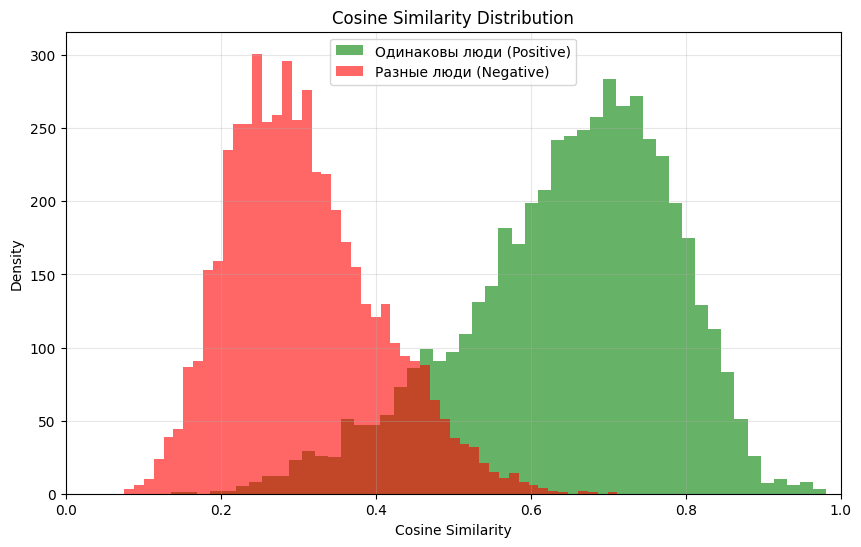

In [ ]:

plt.figure(figsize=(10, 6))

plt.hist(same_person_sims, bins=50, alpha=0.6, color='green', label='Одинаковы люди (Positive)')
plt.hist(diff_person_sims, bins=50, alpha=0.6, color='red', label='Разные люди (Negative)')

plt.title('Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-1.0, 1.0)

plt.show()

Now train the same model using ArcFace-loss. You can try to implement it yourself or use [ready-one](https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#arcfaceloss) from pytorch-metric-learning library.

**To get the second half of the mark for this section you need to achieve 70% accuracy on test set**.

In [ ]:
!pip install pytorch-metric-learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 6.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class FaceRecognitionArcFace(nn.Module):
    def __init__(self):
        super(FaceRecognitionArcFace, self).__init__()

        self.backbone = models.resnet18(pretrained=True)
        num_features = self.backbone.fc.in_features

        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
        )

    def forward(self, x):
        return self.backbone(x)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_metric_learning import losses
import wandb
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(set(train_data.labels))

model_arc = FaceRecognitionArcFace().to(device)
loss_func = losses.ArcFaceLoss(
    num_classes=num_classes,
    embedding_size=512,
    margin=28.6,
    scale=64,
).to(device)

optimizer = optim.Adam([
    {'params': model_arc.parameters(), 'lr': 3e-4},
    {'params': loss_func.parameters(), 'lr': 1e-2}
])

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

wandb.init(project="face-recognition-celeba", config={
    "type": "Fast ArcFace",
    "backbone_lr": 1e-4,
    "head_lr": 1e-2
})


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vazenin (vazenin-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:

def get_accuracy(embeddings, labels, loss_func):
    cosine = loss_func.get_cosine(embeddings)
    _, preds = cosine.max(1)
    return preds.eq(labels).sum().item()

def train_epoch_arcface(model, loss_func, dataloader, optimizer, epoch):
    model.train()
    loss_func.train()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f'Epoch {epoch}', leave=False)

    for batch in pbar:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        embeddings = model(images)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        with torch.no_grad():
             correct += get_accuracy(embeddings, labels, loss_func)
             total += labels.size(0)

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        wandb.log({"train_batch_loss": loss.item()})

    return running_loss / len(dataloader), correct / total

def eval_epoch_arcface(model, loss_func, dataloader):
    model.eval()
    loss_func.eval()

    correct = 0
    total = 0
    losses_list = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            embeddings = model(images)
            loss = loss_func(embeddings, labels)
            losses_list.append(loss.item())

            correct += get_accuracy(embeddings, labels, loss_func)
            total += labels.size(0)

    return correct / total, sum(losses_list) / len(losses_list)


In [ ]:

for epoch in range(1, 26):
    train_loss, train_acc = train_epoch_arcface(model_arc, loss_func, train_loader, optimizer, epoch)
    val_acc, val_loss = eval_epoch_arcface(model_arc, loss_func, val_loader)
    scheduler.step(val_acc)

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f} | Val Acc {val_acc:.2f} | Val Loss {val_loss:.4f}")

    wandb.log({
        "epoch": epoch,
        "val_acc": val_acc,
        "val_loss": val_loss,
        "train_loss": train_loss
    })


Epoch 1:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 1: Train Loss 36.7400 | Val Acc 0.20 | Val Loss 35.0747


Epoch 2:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 2: Train Loss 33.6266 | Val Acc 0.38 | Val Loss 33.5656


Epoch 3:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 3: Train Loss 30.8619 | Val Acc 0.49 | Val Loss 31.7015


Epoch 4:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 4: Train Loss 27.1530 | Val Acc 0.51 | Val Loss 30.6080


Epoch 5:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 5: Train Loss 22.9267 | Val Acc 0.61 | Val Loss 27.7277


Epoch 6:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 6: Train Loss 18.5794 | Val Acc 0.69 | Val Loss 24.7108


Epoch 7:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 7: Train Loss 14.5825 | Val Acc 0.73 | Val Loss 22.3316


Epoch 8:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 8: Train Loss 11.0575 | Val Acc 0.75 | Val Loss 20.3774


Epoch 9:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 9: Train Loss 8.0581 | Val Acc 0.76 | Val Loss 19.4336


Epoch 10:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 10: Train Loss 5.9357 | Val Acc 0.77 | Val Loss 18.2883


Epoch 11:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 11: Train Loss 4.1478 | Val Acc 0.78 | Val Loss 18.3364


Epoch 12:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 12: Train Loss 2.8781 | Val Acc 0.79 | Val Loss 17.2058


Epoch 13:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 13: Train Loss 2.1409 | Val Acc 0.80 | Val Loss 16.5317


Epoch 14:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 14: Train Loss 1.5686 | Val Acc 0.80 | Val Loss 16.5196


Epoch 15:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 15: Train Loss 1.1787 | Val Acc 0.81 | Val Loss 16.1924


Epoch 16:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 16: Train Loss 0.9098 | Val Acc 0.80 | Val Loss 16.1287


Epoch 17:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 17: Train Loss 0.7585 | Val Acc 0.82 | Val Loss 15.4241


Epoch 18:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 18: Train Loss 0.6033 | Val Acc 0.80 | Val Loss 15.8287


Epoch 19:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 19: Train Loss 0.5760 | Val Acc 0.81 | Val Loss 15.4782


Epoch 20:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 20: Train Loss 0.5845 | Val Acc 0.80 | Val Loss 16.0896


Epoch 21:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 21: Train Loss 0.2324 | Val Acc 0.82 | Val Loss 13.8519


Epoch 22:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 22: Train Loss 0.1064 | Val Acc 0.83 | Val Loss 13.4544


Epoch 23:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 23: Train Loss 0.0902 | Val Acc 0.83 | Val Loss 13.6277


Epoch 24:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 24: Train Loss 0.0674 | Val Acc 0.83 | Val Loss 13.4893


Epoch 25:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 25: Train Loss 0.0610 | Val Acc 0.83 | Val Loss 13.3151


Analyze cosine similarity for this model too.

In [ ]:
# YOUR CODE HERE
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm


MAX_PAIRS = 5000
BATCH_LIMIT = 200
def get_arcface_embeddings_map(dataloader, model, max_batches=100):
    model.eval()
    embeddings_map = {}

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, leave=False)):
            if i >= max_batches:
                break

            images = batch['image'].to(device)
            labels = batch['label'].cpu().numpy()

            raw_embeds = model(images)
            embeds = F.normalize(raw_embeds, p=2, dim=1).cpu()

            for emb, label in zip(embeds, labels):
                if label not in embeddings_map:
                    embeddings_map[label] = []
                embeddings_map[label].append(emb)

    return embeddings_map

train_emb_map = get_arcface_embeddings_map(train_loader, model_arc, max_batches=BATCH_LIMIT)
test_emb_map = get_arcface_embeddings_map(test_loader, model_arc, max_batches=100)


same_person_sims = []
diff_person_sims = []

test_labels = list(test_emb_map.keys())
train_labels = list(train_emb_map.keys())
train_labels_set = set(train_labels)

print("\n>>> Начинаем сравнение векторов...")

pair_count = 0
for label in test_labels:
    if label in train_labels_set:
        test_vectors = torch.stack(test_emb_map[label])
        train_vectors = torch.stack(train_emb_map[label])

        sim_matrix = test_vectors @ train_vectors.T

        sims = sim_matrix.view(-1).numpy().tolist()
        same_person_sims.extend(sims)

        pair_count += len(sims)
        if pair_count >= MAX_PAIRS:
            break

pair_count = 0
for label in test_labels:
    test_vectors = torch.stack(test_emb_map[label])

    random_other_label = random.choice(train_labels)
    while random_other_label == label:
        random_other_label = random.choice(train_labels)

    train_vectors = torch.stack(train_emb_map[random_other_label])

    sim_matrix = test_vectors @ train_vectors.T
    sims = sim_matrix.view(-1).numpy().tolist()
    diff_person_sims.extend(sims)

    pair_count += len(sims)
    if pair_count >= MAX_PAIRS:
        break

print(f"Собрано {len(same_person_sims)} 'одинаковых' пар")
print(f"Собрано {len(diff_person_sims)} 'разных' пар")

mean_same = np.mean(same_person_sims)
mean_diff = np.mean(diff_person_sims)
print(f"\nСтатистика:")
print(f"Среднее сходство (Свой):  {mean_same:.4f}")
print(f"Среднее сходство (Чужой): {mean_diff:.4f}")
print(f"Разрыв (Margin):          {mean_same - mean_diff:.4f}")



  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


>>> Начинаем сравнение векторов...
Собрано 5032 'одинаковых' пар
Собрано 5062 'разных' пар

Статистика:
Среднее сходство (Свой):  0.5688
Среднее сходство (Чужой): -0.0179
Разрыв (Margin):          0.5866


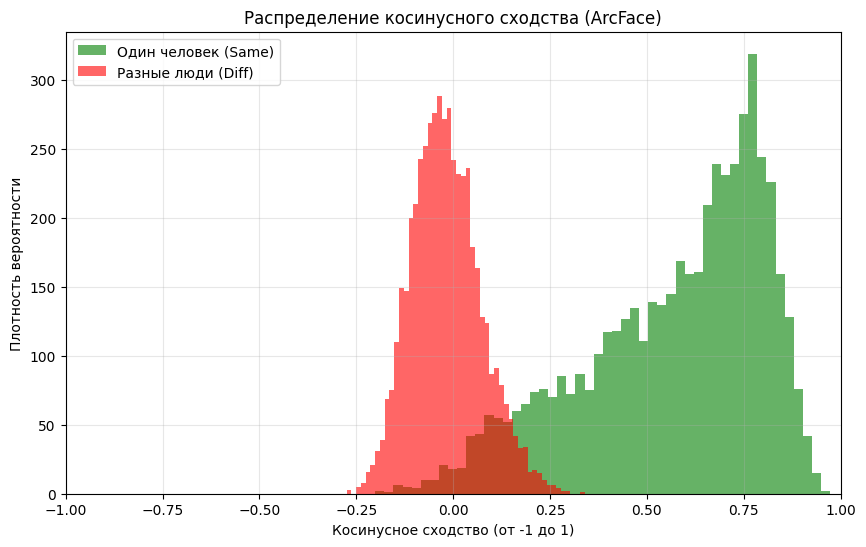

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(same_person_sims, bins=50, alpha=0.6, color='green', label='Один человек (Same)')
plt.hist(diff_person_sims, bins=50, alpha=0.6, color='red', label='Разные люди (Diff)')

plt.title('Распределение косинусного сходства (ArcFace)')
plt.xlabel('Косинусное сходство (от -1 до 1)')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-1.0, 1.0)

plt.show()

Сейчас же получили результаты, при которых разные люди имеют около нулевое среднее косинусное сходство, что как бы тоже логично, что разные люди не похожи друг на друга. И наобороты, в парах, где был один человек, видно, что среднее косинусное сходство тоже выросло, что говорит о том, что один и тот же человек, стал еще более похож на себя, и опять логично... Те можно, сказать, ура победа.

## Bonus task (5 points): Any approach for representation learning

Building a network on task 1 we used an ordinary CE loss and more specific ArcFace loss. But there are many more variants of loss functions that can be used to train neural network and much more schemes for training model. Examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

Now your task is training exactly the same model with exactly the same data using any approach from lecture (if you want to use something different it is better to consult with a teacher). It might be contrastive/triplet/quadruplet loss, any self-supervised pretraining, prototypical network, but not just classification task with different loss.

**To get the whole of the mark for this section you need to achieve at least 70% accuracy on test set and get better results than with CE loss**.
As we don't have a classification layer in our network, we need a custom procedure for accuracy calculation. You can use one of the following procedures:
- calculate accuracy on val and test sets using KNN with embeddings from training set as training points. (easy way)
- compute mean embeddings for every class from training set and use them as reference embeddings.

**Hints**:
- to train model using some losses you'll need to rewrite the Dataset class so it gives you not the random image and its label, but the image, positive/negative images for this image;
- `pytorch-metric-learning` library might be useful too

Посмотрев лекцию, вспомнил, что нужно взять именно триплет лосс)))) и потому что он уже реализован

In [7]:
!pip install pytorch_metric_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 6.5 MB/s eta 0:00:00


In [8]:
# YOUR CODE HERE
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from pytorch_metric_learning import losses, miners, distances
from sklearn.neighbors import KNeighborsClassifier
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import wandb
from tqdm.auto import tqdm
from pytorch_metric_learning import samplers

class FaceNetMetric(nn.Module):
    def __init__(self, embedding_size=512):
        super(FaceNetMetric, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        num_features = self.backbone.fc.in_features

        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, embedding_size)
        )

    def forward(self, x):
        x = self.backbone(x)
        return F.normalize(x, p=2, dim=1)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_net = FaceNetMetric(embedding_size=512).to(device)

distance = distances.CosineSimilarity()

loss_func = losses.TripletMarginLoss(
    margin=0.2,
    distance=distance
).to(device)

miner = miners.TripletMarginMiner(
    margin=0.2,
    distance=distance,
    type_of_triplets="hard"
)

BATCH_SIZE = 128

sampler = samplers.MPerClassSampler(
    labels=train_data.labels,
    m=4,
    batch_size=BATCH_SIZE
)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)

train_loader_knn = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

optimizer = optim.AdamW(model_net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


 Использую майнер из библиотеки с лоссами, поскольку он сам ищет необходимые тройки объектов для триплет лосса и не нужно переписывать класс датасета

In [10]:
def get_embeddings(model, loader):
    model.eval()
    all_embeds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting", leave=False):
            imgs = batch['image'].to(device)
            lbls = batch['label']
            embeds = model(imgs).cpu().numpy()
            all_embeds.append(embeds)
            all_labels.append(lbls)
    return np.concatenate(all_embeds), np.concatenate(all_labels)

def test_knn_accuracy(model, train_loader, test_loader):
    train_em, train_la = get_embeddings(model, train_loader)
    test_em, test_la = get_embeddings(model, test_loader)

    knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
    knn.fit(train_em, train_la)
    acc = knn.score(test_em, test_la)
    return acc

def train_epoch(model, loss_func, miner, loader, optimizer):
    model.train()
    total_loss = 0

    pbar = tqdm(loader)
    for batch in pbar:
        images, labels = batch['image'].to(device), batch['label'].to(device)

        optimizer.zero_grad()
        embeddings = model(images)

        indices_tuple = miner(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item(), triplets=miner.num_triplets)

    return total_loss / len(loader)

In [11]:
wandb.init(project="face-recognition-celeba", name="TripletLoss_Final")

best_acc = 0
EPOCHS = 15

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    train_loss = train_epoch(model_net, loss_func, miner, train_loader, optimizer)

    current_acc = test_knn_accuracy(model_net, train_loader_knn, val_loader)

    print(f"Loss: {train_loss:.4f} | KNN Val Acc: {current_acc:.4f}")


    scheduler.step()
    wandb.log({"train_loss": train_loss, "val_knn_acc": current_acc, "lr": optimizer.param_groups[0]['lr']})

# Итоговая проверка
final_acc = test_knn_accuracy(model_net, train_loader_knn, val_loader)
print(f"\nFinal Validation Accuracy: {final_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vazenin (vazenin-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Epoch 1/15


  0%|          | 0/781 [00:00<?, ?it/s]

Extracting:   0%|          | 0/67 [00:00<?, ?it/s]

Extracting:   0%|          | 0/15 [00:00<?, ?it/s]

Loss: 0.2086 | KNN Val Acc: 0.5032

Epoch 2/15


  0%|          | 0/781 [00:00<?, ?it/s]

Extracting:   0%|          | 0/67 [00:00<?, ?it/s]

Extracting:   0%|          | 0/15 [00:00<?, ?it/s]

Loss: 0.2012 | KNN Val Acc: 0.5852

Epoch 3/15


  0%|          | 0/781 [00:00<?, ?it/s]

Extracting:   0%|          | 0/67 [00:00<?, ?it/s]

Extracting:   0%|          | 0/15 [00:00<?, ?it/s]

Loss: 0.2006 | KNN Val Acc: 0.6342

Epoch 4/15


  0%|          | 0/781 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c7a031f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c7a031f80e0>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
 if w.is_alive(): 
             ^ ^ ^ ^^^^^^^^^^^^^^^^^^^
  

Extracting:   0%|          | 0/67 [00:00<?, ?it/s]

Extracting:   0%|          | 0/15 [00:00<?, ?it/s]

Loss: 0.2003 | KNN Val Acc: 0.6629

Epoch 5/15


  0%|          | 0/781 [00:00<?, ?it/s]

Extracting:   0%|          | 0/67 [00:00<?, ?it/s]

Extracting:   0%|          | 0/15 [00:00<?, ?it/s]

Loss: 0.2002 | KNN Val Acc: 0.6997

Epoch 6/15


  0%|          | 0/781 [00:00<?, ?it/s]

Extracting:   0%|          | 0/67 [00:00<?, ?it/s]

Extracting:   0%|          | 0/15 [00:00<?, ?it/s]

Loss: 0.2002 | KNN Val Acc: 0.7098

Epoch 7/15


  0%|          | 0/781 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c7a031f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c7a031f80e0>^^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^^    ^if w.is_alive():^
^  ^

KeyboardInterrupt: 

Понял, что нужно было не сидеть до 4 утра, а ложиться спать в 12, результаты было бы такими же... А еще колаб ругается на мульти процессинг, но обучение модели это не должно сломать.
Остановил обучение,тк получил Accuracy ≥ 70% и время поджимает

## Bonus task (1 point): Finding trash photos

You have probably noticed that in identification rate calculation we use cosine similarity between embeddings, which includes embeddings' normalization. Actually this is how most of the face recognition algorithms work — they are designed to output a normalized embeddings and any comparison between embeddings is done after the embeddings are normalized. Sometimes it may be beneficial even to add a normalization layer (batchnorm or layernorm with fixed parameters) after the model's embedding layer to make the model output normalized embeddings.

But norms of the unnormalized embeddings can also be used. They can be used to detect trash photos — photos, where the face is presented really badly (e.g. back of the head instead of the forehead or even a photo without any head that has appeared in a dataset due to a mistake in face detection / landmarks detection algorithm).

Empirically it has been found that the higher the embedding's norm, the more the probability of the corresponding photo to be trash is.



**Task**: get the embeddings of photos in a test set. Sort them by their norms. Output the photos whose embeddings norms are the highest. Do they look like normal or trash?

**Doing this task will not give you points above 100% for the whole homework. But if you have any mistakes in previous sections, doing this task may save you 1 point.**

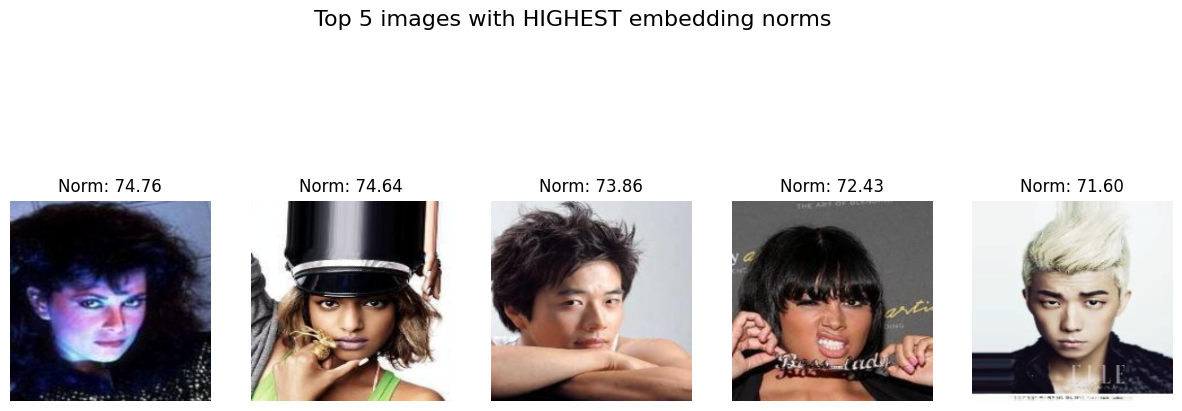

In [13]:

import torch

def denormalize_image(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = tensor.permute(1, 2, 0).cpu().numpy()

    img = img * std + mean
    return np.clip(img, 0, 1)


norms_and_images = []

model_net.eval()

with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)

        raw_embeddings = model_net.backbone(images)

        norms = torch.norm(raw_embeddings, p=2, dim=1)


        for i in range(len(images)):
            norms_and_images.append((norms[i].item(), images[i].cpu()))

norms_and_images.sort(key=lambda x: x[0], reverse=True)
top_n = 5

plt.figure(figsize=(15, 6))
plt.suptitle(f"Top {top_n} images with HIGHEST embedding norms", fontsize=16)

for i in range(top_n):
    norm_val, img_tensor = norms_and_images[i]

    plt.subplot(1, top_n, i+1)
    plt.imshow(denormalize_image(img_tensor))
    plt.title(f"Norm: {norm_val:.2f}")
    plt.axis('off')

plt.show()



Ну эти фото похожи просто на обычные фото

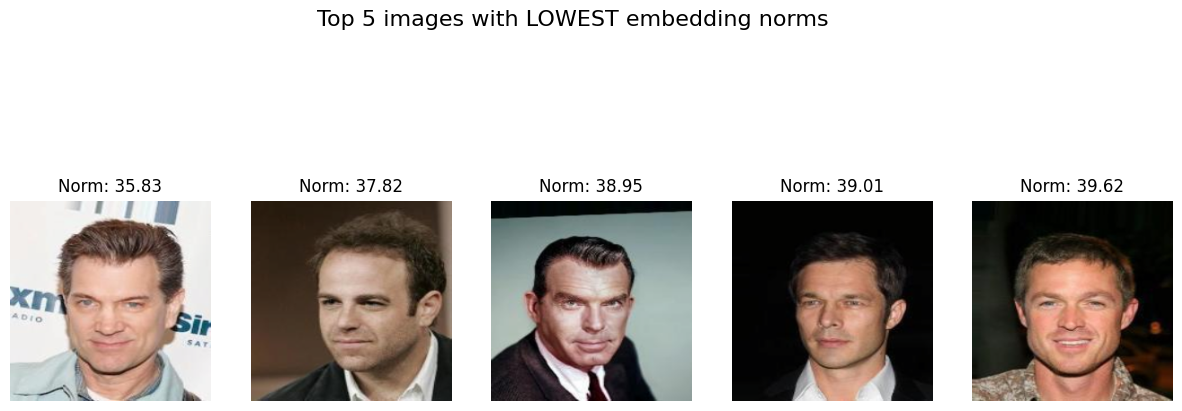

In [14]:
plt.figure(figsize=(15, 6))
plt.suptitle(f"Top {top_n} images with LOWEST embedding norms", fontsize=16)

# Берем с конца списка
for i in range(top_n):
    norm_val, img_tensor = norms_and_images[-(i+1)]

    plt.subplot(1, top_n, i+1)
    plt.imshow(denormalize_image(img_tensor))
    plt.title(f"Norm: {norm_val:.2f}")
    plt.axis('off')

plt.show()